In [92]:
import os
import json
import numpy as np
from skimage import io, color
from myutils import *

In [93]:
images, labels = images_to_numpy_array('dataset2')
print(images.shape)

(2002, 32, 32)


In [94]:
import os
import datetime
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataloader import default_collate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torchvision import transforms

from myutils import *
from keras.preprocessing.image import ImageDataGenerator

In [95]:
MODEL_SAVE_FOLDER = 'model'

In [96]:
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [97]:
# Load images and labels
folder_path = "dataset2"
images, eng_labels = images_to_numpy_array(folder_path)

# Normalize images and encode labels
images = images.astype("float32") / 255.0
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(eng_labels)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Create a dictionary of labels and their inverse transformed values
label_dict = [label_encoder.inverse_transform([label])[0] for label in set(labels)]

# Write the dictionary to a file
with open('labels.list', 'w') as file:
    json.dump(label_dict, file)

In [98]:
print(len(set(labels)))
print(labels)

90
[30 30 30 ... 11 11 11]


In [99]:
# Define transformations for data augmentation (if needed)
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((32,32)),
    transforms.ToTensor(),
])

# Create custom datasets
train_dataset = CustomDataset(X_train, y_train, transform=transform)
test_dataset = CustomDataset(X_test, y_test, transform=transform)

# Define dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [100]:
print(min(labels), max(labels))

0 89


In [101]:
# Initialize the model, loss function, and optimizer
model = create_net()
print(f'created network for labelling {len(set(labels))} classes')
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)
epoch_losses=[]
num_epochs = 200
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_losses.append(epoch_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")


created network for labelling 90 classes


IndexError: Target 79 is out of bounds.

In [ ]:
epoch_losses = np.array(epoch_losses)
epoch_losses

array([4.24703523, 4.2002647 , 4.04388329, 3.83817997, 3.66122656,
       3.50629672, 3.361903  , 3.22522417, 3.09959083, 2.98164409,
       2.87454006, 2.77188813, 2.67510632, 2.58429036, 2.49713051,
       2.41155254, 2.332623  , 2.25331773, 2.17817162, 2.10615469,
       2.03622949, 1.96890101, 1.90571446, 1.84342863, 1.78451943,
       1.72659974, 1.67224576, 1.61959881, 1.56824899, 1.52121773,
       1.47288781, 1.42822595, 1.38515885, 1.3434135 , 1.30309405,
       1.26448997, 1.22759463, 1.19096751, 1.15592683, 1.12461375,
       1.09159701, 1.06112884, 1.03167779, 1.00327213, 0.97498918,
       0.94774264, 0.92332843, 0.89719183, 0.87498555, 0.85254713,
       0.82902285, 0.8095969 , 0.78882025, 0.770378  , 0.74995553,
       0.73136385, 0.71453202, 0.69706204, 0.68065795, 0.66552877,
       0.64904175, 0.63459161, 0.62028683, 0.60586324, 0.59192979,
       0.58107361, 0.56679461, 0.55548545, 0.54264626, 0.53115455,
       0.5214245 , 0.50988053, 0.49932383, 0.48974602, 0.47825

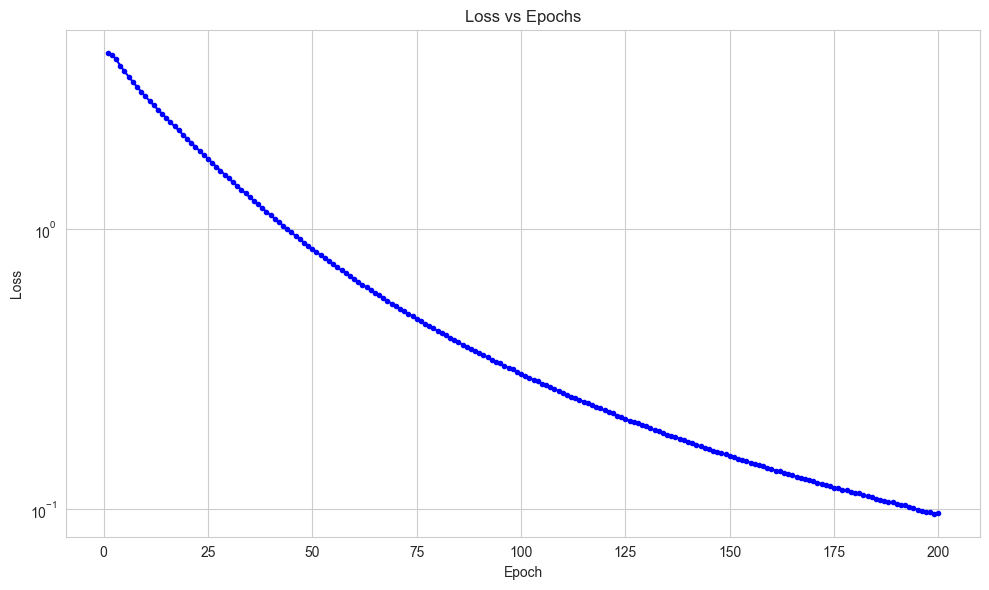

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Example epoch loss data (replace this with your actual 

# Set the style for the plot
sns.set_style("whitegrid")

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(epoch_losses) + 1), epoch_losses, marker='.', color='b', linestyle='-')
plt.title('Loss vs Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
# plt.xticks(range(1, len(epoch_losses) + 1))
# plt.yticks([0.1, 0.2, 0.3, 0.4, 0.5])
plt.yscale('log')
# plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
# Evaluate the model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        # print(outputs.shape)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f"\nAccuracy on test set: {accuracy:.4f}")


Accuracy on test set: 0.9648


In [ ]:
import datetime
# Save the model to a file
# Save the model to a file with a timestamp-based name
timestamp = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
if not os.path.exists(MODEL_SAVE_FOLDER):
    os.makedirs(MODEL_SAVE_FOLDER)
filename = MODEL_SAVE_FOLDER+'/'+f"model_{timestamp}.pth"
torch.save(model.state_dict(), filename)